# Post Sequencing Analysis - From BAM Files To Consensus FASTA, NextClade Clade and Lineage Analysis

## Bioinformatics Analysis Pipeline/Workflow For Next Generation Sequencing (NGS) Data
---
**By Udoh Stephen Nsikak** \
BSc. Biochemistry, MPH-Epidemiology(in progress), M.Sc. Molecular Biology (In View) \
Research Assistant @ Molecular Genetics and Infectious Diseases Research Laboratory (MOGID_RL)

---
**Sample Identification Code: IonCode_108_Seq**

---

## Step 1. QC - Tool (fastqc)

In [1]:
# create a folder to store qc result: html file
!mkdir -p fastqc_results

In [2]:
#run the command to check sequence quality using fastqc
!fastqc IonCode_0108_Seq.bam -o fastqc_results/

Started analysis of IonCode_0108_Seq.bam
Approx 5% complete for IonCode_0108_Seq.bam
Approx 10% complete for IonCode_0108_Seq.bam
Approx 15% complete for IonCode_0108_Seq.bam
Approx 20% complete for IonCode_0108_Seq.bam
Approx 25% complete for IonCode_0108_Seq.bam
Approx 30% complete for IonCode_0108_Seq.bam
Approx 35% complete for IonCode_0108_Seq.bam
Approx 40% complete for IonCode_0108_Seq.bam
Approx 45% complete for IonCode_0108_Seq.bam
Approx 50% complete for IonCode_0108_Seq.bam
Approx 55% complete for IonCode_0108_Seq.bam
Approx 60% complete for IonCode_0108_Seq.bam
Approx 65% complete for IonCode_0108_Seq.bam
Approx 70% complete for IonCode_0108_Seq.bam
Approx 75% complete for IonCode_0108_Seq.bam
Approx 80% complete for IonCode_0108_Seq.bam
Approx 85% complete for IonCode_0108_Seq.bam
Approx 90% complete for IonCode_0108_Seq.bam
Approx 95% complete for IonCode_0108_Seq.bam
Approx 100% complete for IonCode_0108_Seq.bam
Analysis complete for IonCode_0108_Seq.bam


In [2]:
# visualize fastqc results
from IPython.display import IFrame

IFrame("fastqc_results/IonCode_0108_Seq_fastqc.html", width=1000, height=600)

In [3]:
# check flagstat using samtools
!samtools flagstat IonCode_0108_Seq.bam

7056161 + 0 in total (QC-passed reads + QC-failed reads)
7056161 + 0 primary
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
7046837 + 0 mapped (99.87% : N/A)
7046837 + 0 primary mapped (99.87% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


## QC Visualizations for Details

In [1]:
import os
import pandas as pd
import pysam
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
# --------------------------
# 1️⃣ Extract read data from BAM
# --------------------------
def extract_bam_data(bam_path, mapq_threshold=20):
    records = []
    bam = pysam.AlignmentFile(bam_path, "rb")
    for read in bam.fetch(until_eof=True):
        if not read.is_unmapped:
            passes_filter = read.mapping_quality >= mapq_threshold
            records.append({
                'length': read.query_length,
                'mapq': read.mapping_quality,
                'passes_filtering': passes_filter
            })
    bam.close()
    return pd.DataFrame(records) if records else pd.DataFrame()

In [3]:
# 2️⃣ Generate QC plots
# --------------------------
def plot_qc(seq_summary, bam_file, pass_reads, fail_reads):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Pass/Fail bar plot
    axes[0].bar(['Pass', 'Fail'], [pass_reads, fail_reads], color=['#54B8B1', '#EF4135'])
    axes[0].set_ylabel("Read count")
    axes[0].set_title(f"{bam_file} - Pass/Fail Reads")

    # Read length histogram
    axes[1].hist(seq_summary['length'], bins=50, color='skyblue', edgecolor='black')
    axes[1].set_xlabel("Read length (bp)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Read Length Distribution")

    # Mapping quality histogram
    axes[2].hist(seq_summary['mapq'], bins=50, color='orange', edgecolor='black')
    axes[2].set_xlabel("Mapping Quality (MAPQ)")
    axes[2].set_ylabel("Count")
    axes[2].set_title("Mapping Quality Distribution")

    plt.tight_layout()
    plt.show()

In [4]:
# --------------------------
# 3️⃣ Process a single BAM file
# --------------------------
def process_bam_file(bam_path, mapq_threshold=20):
    seq_summary = extract_bam_data(bam_path, mapq_threshold)

    if seq_summary.empty:
        print(f"⚠ No mapped reads found in {os.path.basename(bam_path)}")
        return None

    total_reads = len(seq_summary)
    pass_reads = seq_summary['passes_filtering'].sum()
    fail_reads = total_reads - pass_reads
    pass_pct = 100 * pass_reads / total_reads

    # Show plots inline
    plot_qc(seq_summary, os.path.basename(bam_path), pass_reads, fail_reads)

    return {
        'Sample': os.path.basename(bam_path),
        'Total Reads': total_reads,
        'Pass Reads': pass_reads,
        'Fail Reads': fail_reads,
        'Pass %': round(pass_pct, 2),
        'Mean Read Length': round(seq_summary['length'].mean(), 1),
        'Median Read Length': round(seq_summary['length'].median(), 1),
        'Mean MAPQ': round(seq_summary['mapq'].mean(), 2)
    }


In [5]:
# --------------------------
# 🔹 Process a single BAM file
# --------------------------
def qc_single_bam(bam_file, mapq_threshold=20):
    print(f"Processing {os.path.basename(bam_file)}...")
    result = process_bam_file(bam_file, mapq_threshold)

    if result:
        summary_df = pd.DataFrame([result])  # wrap result in list
        display(HTML(summary_df.to_html(index=False)))
    else:
        print("No result returned.")

Processing IonCode_0108_Seq.bam...


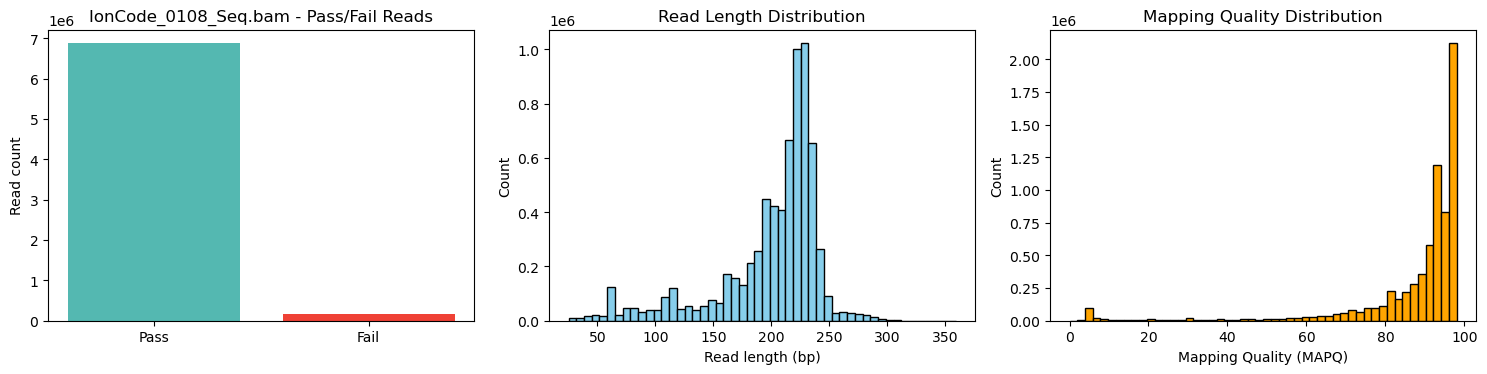

Sample,Total Reads,Pass Reads,Fail Reads,Pass %,Mean Read Length,Median Read Length,Mean MAPQ
IonCode_0108_Seq.bam,7046837,6875954,170883,97.58,200.0,216.0,87.7


In [6]:
qc_single_bam("IonCode_0108_Seq.bam", mapq_threshold=20)

## Bam File Operations 

In [7]:
# index bam file using samtools

!samtools index IonCode_0108_Seq.bam

In [8]:
# sort bam file

!samtools sort -o sorted.IonCode_0108_Seq.bam IonCode_0108_Seq.bam

[bam_sort_core] merging from 11 files and 1 in-memory blocks...


## Visualizing Read Coverage Using Mosdepth

In [4]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

def coverage_plot(bam_file, output_prefix="coverage_output", window=500):
    """
    Run mosdepth on a BAM file and plot coverage.
    
    Parameters:
        bam_file (str): Path to the BAM file.
        output_prefix (str): Prefix for mosdepth output files.
        window (int): Window size for coverage calculation.
    """
    
    # Run mosdepth
    subprocess.run([
        "mosdepth", "-n", "--fast-mode",
        "--by", str(window),
        output_prefix, bam_file
    ], check=True)
    
    # Path to mosdepth output file
    bed_file = f"{output_prefix}.regions.bed.gz"
    
    # Read coverage file
    df = pd.read_csv(bed_file, sep="\t", names=["ref", "start", "end", "depth"])
    
    # Plot coverage
    plt.figure(figsize=(12, 5))
    plt.plot(df["start"], df["depth"], linewidth=0.8)
    plt.title(f"Coverage Plot: {os.path.basename(bam_file)}")
    plt.xlabel("Position")
    plt.ylabel("Depth")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    return df  # optional, return coverage table

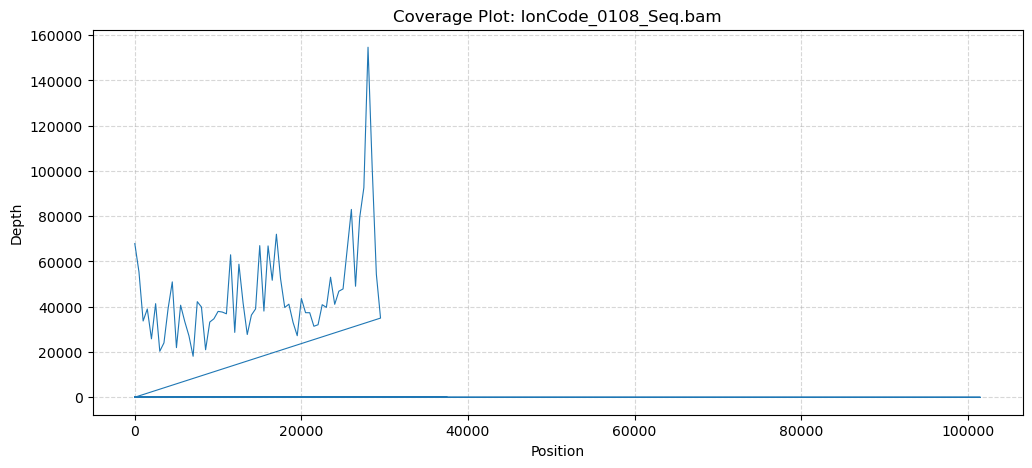

In [11]:
coverage_df = coverage_plot("IonCode_0108_Seq.bam", output_prefix="IonCode_0108_Seq.bam", window=500)

## Step 2. Convert BAM to fastq Tool (samtools)

In [12]:
# convert BAM - Binary Alignment Map file format to fastq
!samtools bam2fq IonCode_0108_Seq.bam > IonCode_0108_Seq.fastq

[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 7056161 reads


## Step 3. Trimming (Single End Trimming) - Tool (trimmomatic)

In [13]:
# Trim off bad reads usijg trimmomatic

!java -jar /usr/share/java/trimmomatic.jar SE -threads 4 -phred33 \
IonCode_0108_Seq.fastq IonCode_0108_Seq_trimmed.fastq \
SLIDINGWINDOW:4:20 LEADING:3 TRAILING:3 MINLEN:50

TrimmomaticSE: Started with arguments:
 -threads 4 -phred33 IonCode_0108_Seq.fastq IonCode_0108_Seq_trimmed.fastq SLIDINGWINDOW:4:20 LEADING:3 TRAILING:3 MINLEN:50
Input Reads: 7056161 Surviving: 5380154 (76.25%) Dropped: 1676007 (23.75%)
TrimmomaticSE: Completed successfully


## Step 4. Post-trimming QC - Tool (fastqc)

In [14]:
# run post-trimming qc to check difference in quality
!fastqc IonCode_0108_Seq_trimmed.fastq -o fastqc_results/

Started analysis of IonCode_0108_Seq_trimmed.fastq
Approx 5% complete for IonCode_0108_Seq_trimmed.fastq
Approx 10% complete for IonCode_0108_Seq_trimmed.fastq
Approx 15% complete for IonCode_0108_Seq_trimmed.fastq
Approx 20% complete for IonCode_0108_Seq_trimmed.fastq
Approx 25% complete for IonCode_0108_Seq_trimmed.fastq
Approx 30% complete for IonCode_0108_Seq_trimmed.fastq
Approx 35% complete for IonCode_0108_Seq_trimmed.fastq
Approx 40% complete for IonCode_0108_Seq_trimmed.fastq
Approx 45% complete for IonCode_0108_Seq_trimmed.fastq
Approx 50% complete for IonCode_0108_Seq_trimmed.fastq
Approx 55% complete for IonCode_0108_Seq_trimmed.fastq
Approx 60% complete for IonCode_0108_Seq_trimmed.fastq
Approx 65% complete for IonCode_0108_Seq_trimmed.fastq
Approx 70% complete for IonCode_0108_Seq_trimmed.fastq
Approx 75% complete for IonCode_0108_Seq_trimmed.fastq
Approx 80% complete for IonCode_0108_Seq_trimmed.fastq
Approx 85% complete for IonCode_0108_Seq_trimmed.fastq
Approx 90% comp

## Step 5. Alignment - Tool (BWA + samtools)

In [18]:
# download reference fasta file NC_044512.2 to align sequence

!wget "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&id=NC_045512.2&rettype=fasta&retmode=text" -O NC_045512.2.fasta

--2025-09-15 15:25:46--  https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&id=NC_045512.2&rettype=fasta&retmode=text
Resolving eutils.ncbi.nlm.nih.gov (eutils.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to eutils.ncbi.nlm.nih.gov (eutils.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘NC_045512.2.fasta’

NC_045512.2.fasta       [  <=>               ]  29.72K  93.3KB/s    in 0.3s    

2025-09-15 15:25:48 (93.3 KB/s) - ‘NC_045512.2.fasta’ saved [30429]



In [15]:
# index reference fasta
!bwa index NC_045512.2.fasta

[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.01 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index NC_045512.2.fasta
[main] Real time: 0.028 sec; CPU: 0.015 sec


In [16]:
# align trimmed fastq file against reference fasta and convert to SAM file format
!bwa mem -t 8 NC_045512.2.fasta IonCode_0108_Seq_trimmed.fastq > IonCode_0108_Seq_aligned.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 481978 sequences (80000115 bp)...
[M::process] read 490228 sequences (80000089 bp)...
[M::mem_process_seqs] Processed 481978 reads in 14.253 CPU sec, 1.761 real sec
[M::process] read 492932 sequences (80000157 bp)...
[M::mem_process_seqs] Processed 490228 reads in 15.377 CPU sec, 1.838 real sec
[M::process] read 488594 sequences (80000100 bp)...
[M::mem_process_seqs] Processed 492932 reads in 15.229 CPU sec, 1.811 real sec
[M::process] read 510158 sequences (80000262 bp)...
[M::mem_process_seqs] Processed 488594 reads in 14.525 CPU sec, 1.733 real sec
[M::process] read 489054 sequences (80000061 bp)...
[M::mem_process_seqs] Processed 510158 reads in 16.975 CPU sec, 2.037 real sec
[M::process] read 521534 sequences (80000013 bp)...
[M::mem_process_seqs] Processed 489054 reads in 15.632 CPU sec, 1.868 real sec
[M::process] read 541754 sequences (80000257 bp)...
[M::mem_process_seqs] Processed 521534 reads in 15.295 CPU sec,

In [17]:
# sort and convert the SAM file to BAM file using samtools
!samtools sort -o IonCode_0108_Seq_aligned_sorted.bam IonCode_0108_Seq_aligned.sam

[bam_sort_core] merging from 2 files and 1 in-memory blocks...


In [18]:
# index BAM file: converting it to BAI - Binary Alignment Index file format (.bai)
!samtools index IonCode_0108_Seq_aligned_sorted.bam

## Visualization to compare read quality after alignment

Processing IonCode_0108_Seq_aligned_sorted.bam...


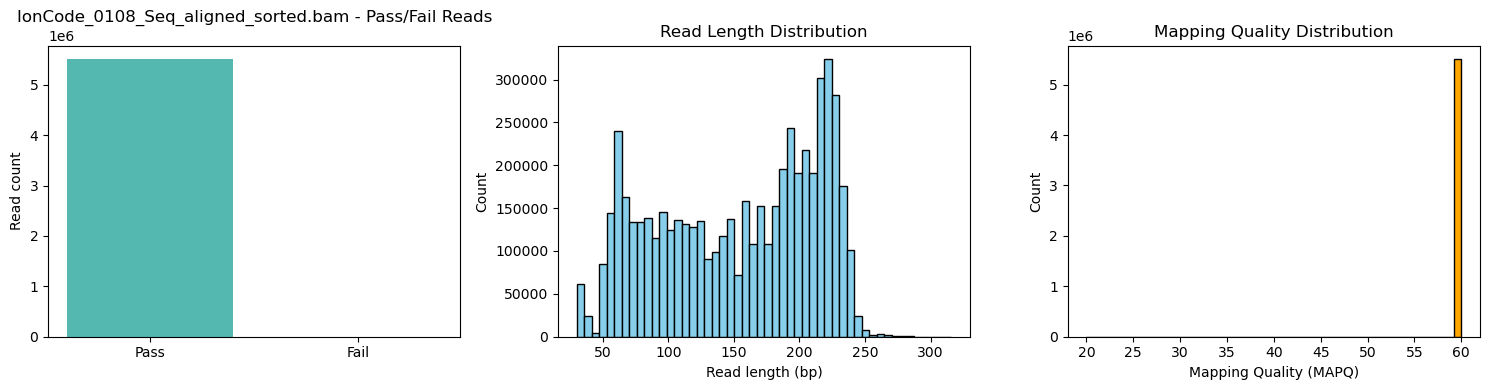

Sample,Total Reads,Pass Reads,Fail Reads,Pass %,Mean Read Length,Median Read Length,Mean MAPQ
IonCode_0108_Seq_aligned_sorted.bam,5502746,5502746,0,100.0,153.1,163.0,60.0


In [19]:
qc_single_bam("IonCode_0108_Seq_aligned_sorted.bam", mapq_threshold=20)

## Comparing the Depth and Coverage after Re-alignment

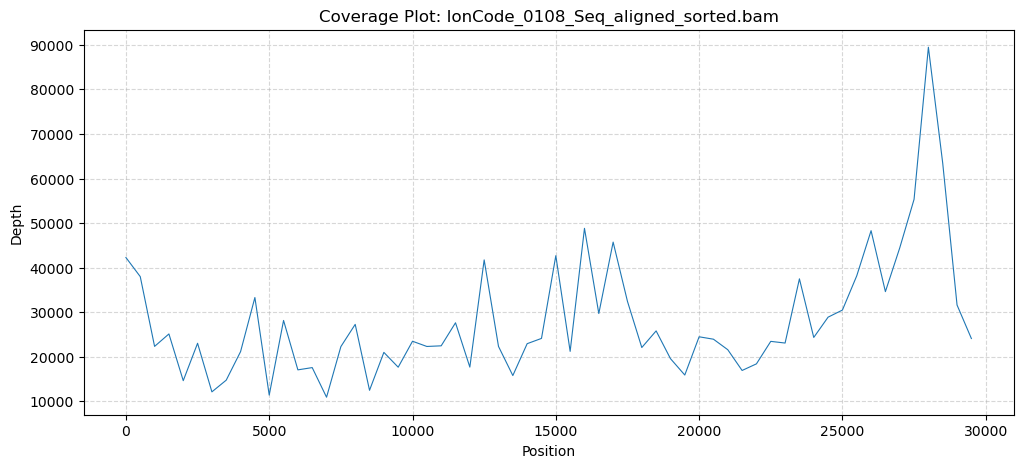

In [20]:
coverage_df = coverage_plot("IonCode_0108_Seq_aligned_sorted.bam", output_prefix="IonCode_0108_Seq", window=500)

## Step 6. Variant Calling - Tool (iVar)

In [ ]:
# carry out variant calling using samtools and iVar

!samtools mpileup -aa -A -d 0 -B -Q 0 IonCode_0108_Seq_aligned_sorted.bam \
| ivar variants \
-p variants \
-q 20 \
-t 0.3 \
-r NC_045512.2.fasta

[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)
A GFF file containing the open reading frames (ORFs) has not been provided. Amino acid translation will not be done.


In [5]:
df = pd.read_csv("variants.tsv", sep="\t")

df

,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,ALT_FREQ,TOTAL_DP,PVAL,PASS,GFF_FEATURE,REF_CODON,REF_AA,ALT_CODON,ALT_AA
0,NC_045512.2,241,C,T,14,12,32,8836,6900,29,0.998305,8851,0,True,NaN,NaN,NaN,NaN,NaN
1,NC_045512.2,1426,C,T,63,36,31,10421,3869,31,0.993706,10487,0,True,NaN,NaN,NaN,NaN,NaN
2,NC_045512.2,2325,C,T,7226,5559,31,3418,2388,25,0.320217,10674,0,True,NaN,NaN,NaN,NaN,NaN
3,NC_045512.2,3037,C,T,6,6,32,21550,14314,31,0.999675,21557,0,True,NaN,NaN,NaN,NaN,NaN
4,NC_045512.2,3251,G,A,22,7,28,10429,3627,29,0.997895,10451,0,True,NaN,NaN,NaN,NaN,NaN
5,NC_045512.2,3811,C,T,4,3,33,15823,11197,32,0.999747,15827,0,True,NaN,NaN,NaN,NaN,NaN
6,NC_045512.2,3832,C,-N,5784,4494,27,2804,0,20,0.482201,5815,0,True,NaN,NaN,NaN,NaN,NaN
7,NC_045512.2,6608,A,G,213,207,32,4470,900,31,0.954516,4683,0,True,NaN,NaN,NaN,NaN,NaN
8,NC_045512.2,7262,C,T,1850,576,30,4885,826,27,0.725316,6735,0,True,NaN,NaN,NaN,NaN,NaN
9,NC_045512.2,9314,G,-N,16381,7603,28,5297,0,20,0.322104,16445,0,True,NaN,NaN,NaN,NaN,NaN


## Step 7. Consensus Generation - Tool (iVar)

In [1]:
# generate the consensus fasta using samtools and iVar

!samtools mpileup -aa -A -d 0 -B -Q 0 IonCode_0108_Seq_aligned_sorted.bam | \
ivar consensus \
  -p consensus \
  -t 0.5 \
  -n N \
  -m 10

[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)
Minimum Quality: 20
Threshold: 0.5
Minimum depth: 10
Regions with depth less than minimum depth covered by: N
Reference length: 29903
Positions with 0 depth: 63
Positions with depth below 10: 66


In [2]:
# change file name and format to ".fasta"
!mv consensus.fa IonCode_0108_Seq.fasta

In [ ]:
!less IonCode_0108_Seq.fasta

>Consensus_consensus_threshold_0.5_quality_20
NNNNNNNNNNNNNNNNNNNNNNNGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTG

In [2]:
# apply function to count total number of sequence

from Bio import SeqIO

def count_bases_and_ns(fasta_file):
    """
    Count total A/T/C/G bases, number of N's, and sequences in a FASTA file.
    
    Parameters:
    fasta_file (str): Path to the FASTA file.
    
    Returns:
    dict: {
        "sequences": int,
        "atcg_bases": int,
        "n_bases": int
    }
    """
    sequences = 0
    atcg_bases = 0
    n_bases = 0
    
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq_str = str(record.seq).upper()
        sequences += 1
        atcg_bases += sum(base in "ATCG" for base in seq_str)
        n_bases += seq_str.count("N")
    
    return {
        "sequences": sequences,
        "atcg_bases": atcg_bases,
        "n_bases": n_bases
    }


In [3]:
consensus_file = "IonCode_0108_Seq.fasta"
result = count_bases_and_ns(consensus_file)

print(f"Total sequences: {result['sequences']}")
print(f"A/T/C/G bases: {result['atcg_bases']}")
print(f"N bases: {result['n_bases']}")

Total sequences: 1
A/T/C/G bases: 29835
N bases: 66


In [4]:
try:
    ambiguous_bases = (result['n_bases'] / (result['atcg_bases'] + result["n_bases"])) * 100
    print(f"The total proportion of ambiguous bases (Ns) in this sequence is {round(ambiguous_bases, 2)}%")

    # screen sequence according to the percentage of ambiguous bases
    if ambiguous_bases <= 5:
        print("Sequence is considered good/acceptable and can be considered for submission.")
    elif 5 < ambiguous_bases <= 10:
        print("Sequence is flagged as low coverage and may or may not be considered for submission.")
    else:
        print("Sequence has poor quality and cannot be considered for submission.")

except ZeroDivisionError:
    print("""
    The sequence has no A/T/C/G bases. Cannot calculate percentage of Ns.
    
    Your sequence has no usable consensus. This might be due to low amount of quality reads and coverage.
    """)

The total proportion of ambiguous bases (Ns) in this sequence is 0.22%
Sequence is considered good/acceptable and can be considered for submission.


**For GISAID/NCBI submission, the general expectation is:**

><5% Ns → considered good/acceptable.

>5–10% Ns → borderline, may pass but flagged as low coverage.

>10% Ns → usually rejected or discouraged because of poor quality.

In [7]:
# clean ambiguous bases from the sequence
!sed '/^>/! s/N//g' IonCode_0108_Seq.fasta > IonCode_0108_Seq_clean.fasta

In [13]:
!grep -v ">" IonCode_0108_Seq_clean.fasta | tr -d '\n' | wc -c

29835


## Step 8. Lineage/Clade Check Using NextClade

In [35]:
# download nextclade dataset
!nextclade dataset get --name sars-cov-2 --output-dir ./nextclade_dataset

In [8]:
# input your fasta file and check the lineage
!nextclade run -D ./nextclade_dataset -O ./nextclade_results IonCode_0108_Seq.fasta


In [6]:
df = pd.read_csv("nextclade_results/nextclade.tsv", sep="\t")
df

,index,seqName,clade,clade_display,clade_who,clade_nextstrain,partiallyAliased,Nextclade_pango,qc.overallScore,qc.overallStatus,...,qc.frameShifts.status,qc.stopCodons.stopCodons,qc.stopCodons.totalStopCodons,qc.stopCodons.score,qc.stopCodons.status,totalPcrPrimerChanges,pcrPrimerChanges,failedCdses,warnings,errors
0,0,Consensus_consensus_threshold_0.5_quality_20,20A,20A,NaN,20A,B.1.462,B.1.462,181.920868,bad,...,mediocre,NaN,0,0,good,0,NaN,NaN,NaN,NaN
